<a href="https://colab.research.google.com/github/glingden/Natural-Language-Processing-NLP/blob/master/Bert_TextSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Semantic Text Similarity
In this notebook, the BERT (bert-base-uncased) model is used for finding  semantic text similarity between a pair of sentences.  The [STS_B benchmark](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset is used for this work. This dataset consists of separate training, validation and test data. The work in this notebook contains two parts:
1. Sentence level embedding extraction from the pre-trained  bert model and apply cosine similarity between the pair sentences (No fine-tunned, but only using sentence vector representation from the pretrained model)

2. Fine-tune: The STS_B train dataset is used for fine tunning the model and validaiton dataset is used for model validation. And, the fine-tunned model is used to predict the test dataset.

In [17]:
#import necessary libraries
import pandas as pd
import tensorflow as tf
import torch

GPU from Google Colab is used in this work. So, check if GPU is avaiable, and if not rasie error. We have to identify and specify GPU as device in order to use it. 




In [ ]:
#check GPU is available or not 
if torch.cuda.is_available():

  device = torch.device("cuda")
  print('Found GPU :', torch.cuda.get_device_name(0))

else:
    print('Not found, use CPU instead')
    device = torch.device("cpu")
  


Found GPU : Tesla K80


# **Load Dataset** <br> 

Dataset is stored at  Google drive. So, google drive  is mounted at '/content/drive' to access them.

In [18]:
#mount the drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#load dataset
dataset_types = [ "sts-train.csv", "sts-dev.csv", "sts-test.csv",] # 3 datasets
col_names = ["genre", "file", "years", "_", "score(0-5)", "sentence_1", "sentence_2"] #columns names

#collect as a list of pandas dataframes
df_list = []
for dataset in dataset_types:
  df = pd.read_csv("/content/drive/My Drive/Google_Colab/stsbenchmark_dataset/"+ dataset, 
                 delimiter=',' , 
                 header= None,
                 names= col_names
                )
  

  df_list.append(df)

In [20]:
#separate dataset (train, dev and test)
df_train = df_list[0]
df_dev = df_list[1]
df_test = df_list[2]


In [ ]:
#show random 5 rows in each dataset (train, dev and test)
print("Show train_data shape: {}".format(df_train.shape))
print("Show dev_data shape: {}".format(df_dev.shape))
print("Show test_data shape: {}".format(df_test.shape))
print("Show Random 5 rows:")
df_train.sample(5)



Show train_data shape: (5749, 7)
Show dev_data shape: (1500, 7)
Show test_data shape: (1379, 7)
Show Random 5 rows:


,genre,file,years,_,score(0-5),sentence_1,sentence_2
3128,main-news,MSRpar,2012train,266,4.0,In an E-mail statement to the Knoxville News S...,I am not giving any consideration to resignati...
1125,main-captions,images,2014,177,2.2,A person riding a dirt bike in the outdoors.,A person jumping a motorbike in the air.
1484,main-captions,images,2014,726,1.8,A close-up of a sheep in the grass.,"A close-up of a lamb with its ear tagged, stan..."
2097,main-forum,deft-forum,2014,97,3.4,"I have years of ""Neener Neener"" rights Usuall...","I have years of ""Neener Neener"" rights they a..."
4358,main-news,headlines,2014,14,3.8,Five killed in Belgian coach crash,Teenagers among 5 dead in Belgian bus crash


# **Text Preprocessing**

Prepare text data according to BERT format. We have to tokenize the text sequences/sentences as per the BERT requirements before feeding them into Model. For this, we will use BertTokenizer from hugging face.

In [21]:
#tranformer library from Hugging face
!pip install transformers

In [23]:
#import libraries from hugging face
from transformers import BertTokenizer, BertModel
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased') #initiate tokenizer 

In [ ]:
#check transformer
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('just normal'))"

2020-06-30 09:26:38.841473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
[{'label': 'POSITIVE', 'score': 0.9987471699714661}]


#Hugging face Tokenizer
Example of Tokenizer

In [24]:
#text
text = df_train.sentence_1[0]
print(text)


#Tokenize the text
tokenize = tokenizer.tokenize(text)
print(tokenize)


#encode text
input_ids =tokenizer.encode(text) # add '[CLS]' and '[SEP]' tokens
print(input_ids)

#convert input_ids back to tokens
ids_to_tokens= tokenizer.convert_ids_to_tokens(input_ids)
print(ids_to_tokens)

#convert tokens back to input_ids
ids_to_tokens= tokenizer.convert_tokens_to_ids(ids_to_tokens)
print(ids_to_tokens)
print()

#Encode text with input_ids, token_type_ids, and attention_mask
print(tokenizer(text)) #just use tokenizer and pass text to encode


A plane is taking off.
['a', 'plane', 'is', 'taking', 'off', '.']
[101, 1037, 4946, 2003, 2635, 2125, 1012, 102]
['[CLS]', 'a', 'plane', 'is', 'taking', 'off', '.', '[SEP]']
[101, 1037, 4946, 2003, 2635, 2125, 1012, 102]

{'input_ids': [101, 1037, 4946, 2003, 2635, 2125, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


#Count tokens in Sequences
Since we have to have equal length of every sequence, check the maximun token length in every sentences in all datasets and  we will use this max length for all sequences as fix-length size while doing sequence padding.

Or, we may use the other  best max-length. So that there is no risk of loss of much tokens while doing truncating/padding  in the sequences.

In [ ]:
#counts tokens in sequences
dataset_all = [df_train.sentence_1, df_train.sentence_2, df_dev.sentence_1, df_dev.sentence_2,df_test.sentence_1,df_test.sentence_2] #list of all dataset
dataset_type_name = ['df_train.sentence_1', 'df_train.sentence_2', 'df_dev.sentence_1', 'df_dev.sentence_2', 'df_test.sentence_1', 'df_test.sentence_2'] #name of dataset

max_len = 0 # tokens max count in overall datasets
token_len_list = [] #store token counts for each dataset
higest_token_len = {} # store higest token counts in each dataset


#zip and iterate over all datasets
for nam_data, each_dataset in zip(dataset_type_name, dataset_all):
  token_len_dataset = [] #store each sequence count of each dataset
  max_len_seq= 0 # max count of  sequence in each dataset 

  #iterate over sequences in each dataset
  for sent in each_dataset:
    tokens = tokenizer.encode(sent) #tokenize
    tokens_len = len(tokens) # count length
    token_len_dataset.append(tokens_len) 
    
    
    # keep tracking the higest counts in each dataset
    if tokens_len > max_len_seq:
      max_len_seq = tokens_len
    
    #higest count overall dataset
    if max_len_seq > max_len:
      max_len = max_len_seq
       
  higest_token_len[nam_data] =  max_len_seq 
  token_len_list.append(token_len_dataset)

print("Higest tokens number in 3 datasets: %s ." % (max_len))
print()
print('Higest counts in each dataset:\n')
higest_token_len


Higest tokens number in 3 datasets: 70 .

Higest counts in each dataset:



{'df_dev.sentence_1': 45,
 'df_dev.sentence_2': 53,
 'df_test.sentence_1': 43,
 'df_test.sentence_2': 46,
 'df_train.sentence_1': 70,
 'df_train.sentence_2': 63}

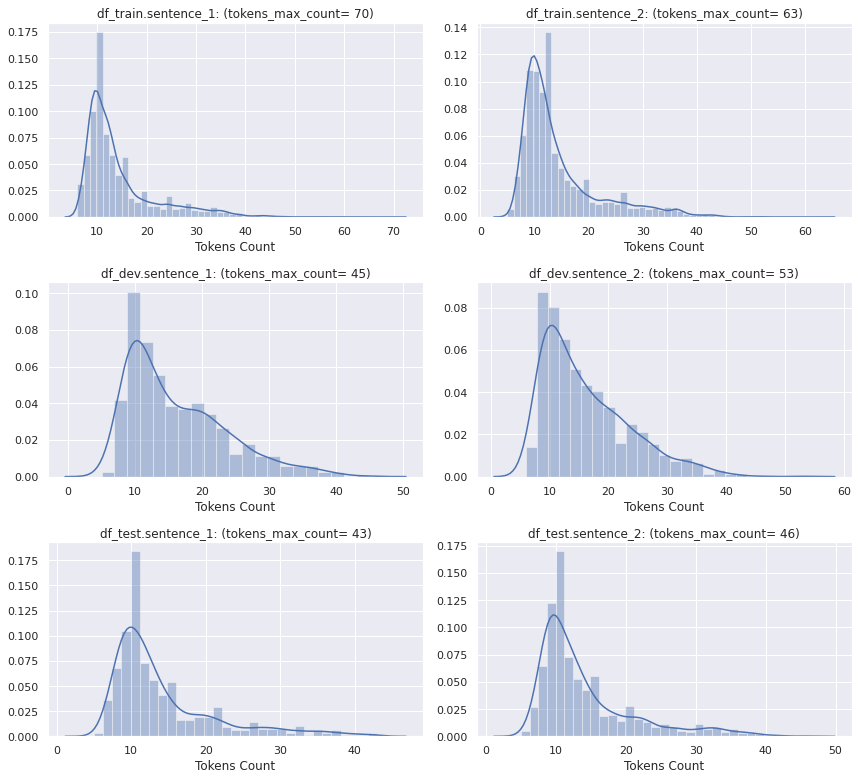

In [ ]:
#Plot the diagram to show the tokens' length distribution in dataset
import seaborn as sns
from matplotlib import pyplot as plt

# data to plot
data = token_len_list 

#creates subplots  with nrows=3, ncols=2
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,11))
sns.set(style='darkgrid') #set plot style

#change 'axes' to 1d, zip and emumerate
for i, (name, axe)  in enumerate(zip(dataset_type_name, axes.flatten())):
  sns.distplot(token_len_list[i], axlabel ='Tokens Count', ax=axe) #distplot type
  name = name + ': (tokens_max_count= '+ str(higest_token_len[name]) + ')' #title (for example: df_train.sentence_1:(max_count=70))
  axe.set_title(name) #title for each suplots
fig.tight_layout()#fit nicely
plt.show()


**Observation**:  The max tokens count is 70 in a sequence in all dataset. Among all dataset, the train dataset(both in sentence1 and sentence 2) have higer tokens count of 70 and 63 respectively. But, the majority of tokens length are about 40 counts. 

So, this gives us the good idea for selecting the max-length of tokens in a sequence.  We can put our max-length of 60, so that we will not truncate more tokens(loss information) and also don't have to do more padding.

But, we will use 120 tokens length (double of a single sequence) for the model architecure where a pair of sentence are required to feed together.

# Part-1: Sentence Level Embedding Extraction
For Sentence Embedding Extraction, last 4 hidden layers are concatenated and mean pooling of words in a sequence/sentence is done. So, the final dimension of a sentence vector representation is 768*4 =3072.

In [87]:
#function to extract sentence level embedding 
def sent_embedding(sent, model):
  """
   Concatenate from last 4 layers and Mean pooling of words in  a sequence

  Args:
     sent: list of sentences
     model: BERT pre-trained model

  Returns:
     sent_embedding: 2d tensor 

  """

  #tokenize sequence into fix-length size of 60 tokens 
  #add ['CLS'], ['SEP'] and return 2d 'input_ids', 'attention_masks' and 'token_type_ids'
  tokens = tokenizer( sent,  #list of strings
                      padding = 'max_length', # padding max-length
                      truncation = True, # truncate max-length
                      max_length = 60, # max tokens size
                      return_tensors='pt',  #return pytorch tensor
                      verbose = False # stop throwing warnings
                     )
    


  #feed input_ids to BERT model
  with torch.no_grad():  # reduces memory consumption
        outputs = model(tokens['input_ids'], tokens['attention_mask']) # feed input_ids, attention_mask
        hidden_states = outputs[2] # all hidden layers

   
  '''
  #sent_embeding = torch.cat(tuple([hidden_states[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1)
  #sent_embeding = hidden_states[-2].mean(dim=1) '''

  concat_embeding = torch.cat(tuple([hidden_states[i] for i in [-4,-3,-2,-1]]), dim = 2) #concatenation last 4 hidden layers
  print('Concatenated Vector Dimension: ',concat_embeding.shape )
  padded = tokens['attention_mask'].unsqueeze(2) # insert size one at 2 position to make 3dimesion
  mul_out = torch.mul(concat_embeding, padded)# make zeros vector for paddding tokens
  sent_embeding = mul_out.mean(dim=1) # average pooling  of tokens
  print('Sentence Embedding Dimension: ',sent_embeding.shape )
   
  return sent_embeding



In [26]:
#initiate the pre-trained model
model = BertModel.from_pretrained(  'bert-base-uncased',
                                     output_hidden_states = True # return all hidden-states
                                    )
#put model in evaluation
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [85]:
tokens = tokenizer( df_train.sentence_1.tolist()[:1],  #list of strings
                      padding = 'max_length', # padding max-length
                      truncation = True, # truncate max-length
                      max_length = 60, # max tokens size
                      return_tensors='pt',  #return pytorch tensor
                      verbose = False # stop throwing warnings
                     )

In [86]:
tokens['input_ids']

tensor([[ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

#Extract Sentence level embedding
Now, lets extract sentence level vector representation for all 3 datasets. 

In [88]:
%%time
#dev dataset
df_dev_sentence_1 = sent_embedding(df_dev.sentence_1.tolist(), model)
df_dev_sentence_2 = sent_embedding(df_dev.sentence_2.tolist(), model)

Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
CPU times: user 8min 40s, sys: 11.1 s, total: 8min 51s
Wall time: 8min 52s


In [89]:
%%time
#test dataset
df_test_sentence_1 = sent_embedding(df_test.sentence_1.tolist(), model)
df_test_sentence_2 = sent_embedding(df_test.sentence_2.tolist(), model)

Concatenated Vector Dimension:  torch.Size([1379, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1379, 3072])
Concatenated Vector Dimension:  torch.Size([1379, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1379, 3072])
CPU times: user 7min 59s, sys: 2.55 s, total: 8min 1s
Wall time: 8min 2s


In [90]:
%%time
#train dataset
train_embed_sentence_1 =  []
train_embed_sentence_2 =  []

#make batches to avoid crash of RAM
for x in range(0, df_train.shape[0], 1500):
  embed_1= sent_embedding(df_train.sentence_1.tolist()[x: x+1500], model)
  embed_2= sent_embedding(df_train.sentence_2.tolist()[x: x+1500], model)
  train_embed_sentence_1.extend(embed_1)
  train_embed_sentence_2.extend(embed_2)

  

Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1500, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1500, 3072])
Concatenated Vector Dimension:  torch.Size([1249, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1249, 3072])
Concatenated Vector Dimension:  torch.Size([1249, 60, 3072])
Sentence Embedding Dimension:  torch.Size([1249, 3072])
CPU times: user 33min 14s, sys: 10.1 s, total: 33min 24s
Wall ti

In [91]:
#sentence level vector represetnation in train dataset
df_train_sentence_1 = torch.stack(train_embed_sentence_1) # change list of tensors >>> 2d tensor
df_train_sentence_2 = torch.stack(train_embed_sentence_2) # change list of tensors >>> 2d tensor


# Calculate Cosine Similarity
Now, sentence level vector representation of each pair sentence is used to compute cosine similarity. Cosine similarity is calculated on all 3 datasets just to know how the extracted sentence level embedding perform.

In [119]:
import numpy as np
from scipy.spatial.distance import cosine #cosine distance
from sklearn.preprocessing import MinMaxScaler # minmax scaling
from scipy.stats import pearsonr # pearson correlation
from scipy.stats import spearmanr # spearman correlation
from collections import defaultdict 


In [116]:
#function to calculate similarity score 
def calc_similarity_score(embed_1, embed_2):

  """
  Calcualte cosine simialrity between a pair of sentences.
  
    Args:
      embed_1(numpy array): first sentence embedding
      embed_2(numpy array): second sentence embedding

    Return:
      scaled_cosine_score(list) : cosine score between embed_1 
      and embed_2 with range (0,5)
  """
  
  #collect similarity score
  cosine_sim_score = []
  
  for x,y in zip(embed_1, embed_2):

    distance = cosine(x, y) # cosine distance
    cosine_sim = 1 - distance # cosine similarity
    cosine_sim_score.append(cosine_sim) 

  


  #scaled the similarity score to (0,5)
  scaler = MinMaxScaler(feature_range=(0,5)) # initiate minmaxscaler
  scaled_cosine_score = scaler.fit_transform(np.transpose([cosine_sim_score])) #scaled to (0,5)
  
  return scaled_cosine_score.round(3)
  

#Pearson and Spearman score
Calculate the Pearson and Spearman correlation by comparing with computed cosine similarity score with gold score.

In [122]:
#Pearson and Spearman score
first_sent_embd = [df_train_sentence_1, df_dev_sentence_1, df_test_sentence_1] #first sentence embedding
second_sent_embd = [df_train_sentence_2, df_dev_sentence_2, df_test_sentence_2] #second sentence embedding
gold_labels = [df_train.loc[:,'score(0-5)'].values, df_dev.loc[:,'score(0-5)'].values, df_test.loc[:,'score(0-5)'].values ] #gold scores
data_type = ['Train', 'Validation', 'Test'] #datasets names

#zip and enumerate 'first_sent_embd' and 'second_sent_embd'
for i, (first_sent, second_sent) in enumerate(zip(first_sent_embd,second_sent_embd)):
  cosine_sim_score = calc_similarity_score(first_sent, second_sent) #cosine similarity score
  cosine_sim_score = cosine_sim_score.flatten()# change to 1d

  person_score, _ = pearsonr(gold_labels[i], cosine_sim_score) #pearson score
  pear_spear_score['pearson'] = person_score

  sperman_score, _ = spearmanr(gold_labels[i], cosine_sim_score)#spearman score
  pear_spear_score['spearman'] = sperman_score

  print(data_type[i], 'data: ')
  print('=='*6)
  print("Pearson score: {} \nSpearman score: {}".format(person_score, sperman_score))
  print()
  


Train data: 
Pearson score: 0.5090061328623349 
Spearman score: 0.4820996486643903

Validation data: 
Pearson score: 0.5929747726822713 
Spearman score: 0.5956354804822067

Test data: 
Pearson score: 0.4767255590987412 
Spearman score: 0.4695436549422946



# Part-2: Fine-tune Bert
The custom model is defined using pytorch nn.module. And, The pre-trained BERT(bert-base-uncased) model is fine-tunned with STS-b train dataset. 

In [ ]:
#import necessary libraries
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader #pytorch dataset and dataloader
from transformers import  AdamW, get_linear_schedule_with_warmup #optimizer and learning rate scheduler
from collections import defaultdict  #store train, valid scores

# Custom Model
The two different network stuctures are tried  for fine-tuning the pre-trained model. They are as follows:

1. Siamese Network: In this Siamese Network structure, two different sentences(a pair of sentences) are encoded separetely meaning they are encoded one by one, and their final vecotors are used to calculate the cosine similarity.  The output layer is just the cosine similairty. No additonal layers.  The vector representation of a sentence is the concatenation of the last 4 hidden layers, and mean pooling of the tokens in a inputed sequence. 

2. Regression Model: In this fine-tuning, the Linear Regression output layer is added on the top of Bert. The two sentences(a pair of sentences) are feeded and encoded together. And, the final output is the regression ouput.

The Mean Square Error(MSE) Loss is used as loss function  for both the Netowrk structures.

In [ ]:
#define custom model
class SentenceSimilarityModel(nn.Module):
  """Bert model to calculate cosine similarity between a pair of sentences"""
  
  def __init__(self):
    super(SentenceSimilarityModel, self).__init__()
    self.bert = BertModel.from_pretrained(  'bert-base-uncased',
                                          output_hidden_states = True # return all hidden-states
                                          ) #initiate pretrained bert model
    self.drop = nn.Dropout(p=0.3) #dropout 30 percent
    self.regression = nn.Linear(768,1) #Linear with one output
    self.cosine_sim = nn.CosineSimilarity(dim=1, eps=1e-6) # cosine similarity

    
  #forward pass
  def forward(self, input_ids, attention_masks,  model_type, token_type_ids=None):
    """
        Args:
          input_ids_1(tensor) : input_ids of first sentence
          input_ids_2(tensor) : input_ids of second sentence
          attention_mask_1(tensor): attention_mask of first sentence
          attention_mask_2(tensor): attention_mask of second sentence
          model_type(str): type of model architecture to calculate ouput
          (for example, 'regression' or 'cosine')

       Returns:
          cosine_score(1d tensor): Cosine similarity between a pair of sentences
          or
          regre_output(1d tensor) : regression output
    """
    

    #if model type is 'Siamese Network' i.e. cosine output
    if  model_type == 'cosine':
      
      #first sentence embedding
      input_1 = input_ids['first_sent'].to(device)
      atten_1 = attention_masks['first_sent'].to(device)
      output_1 = self.bert(
          input_ids = input_1,
          attention_mask = atten_1
      )
      hidden_states_1 = output_1[2] #hidden states only
      #hidden_states_1 = self.drop(hidden_states_1)
      #sent_embeding_1 = torch.cat(tuple([hidden_states_1[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1) #concat last four hidden layers
      concat_embeding_1 = torch.cat(tuple([hidden_states_1[i] for i in [-4,-3,-2,-1]]), dim = 2) # last four hidden layers
      padded_1 = atten_1.to(device).unsqueeze(2) #insert size one at position 2
      mul_out_1 = torch.mul(concat_embeding_1, padded_1)#make zeros vector for paddding tokens
      sent_embeding_1 = mul_out_1.mean(dim=1) # pooling average of tokens
      #out_1 = mul_out_1[:, 0, :] #cls token
  
    

      #second sentence embedding
      input_2 = input_ids['second_sent'].to(device)
      atten_2 = attention_masks['second_sent'].to(device)
      output_2 = self.bert(
          input_ids = input_2,
          attention_mask = atten_2
      )
      hidden_states_2 = output_2[2]
      #hidden_states_2 = self.drop(hidden_states_2)
      #sent_embeding_2 = torch.cat(tuple([hidden_states_2[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1)
      concat_embeding_2 = torch.cat(tuple([hidden_states_2[i] for i in [-4,-3,-2,-1]]), dim = 2) # last four layers
      padded_2 = atten_2.unsqueeze(2) #insert size one at position 2
      mul_out_2 = torch.mul(concat_embeding_2, padded_2)#make zeros vector for paddding tokens
      sent_embeding_2 = mul_out_2.mean(dim=1) # pooling average of tokens
      #out_2 = mul_out_2[:, 0, :] #cls token
  
      #calculate cosine similarity
      cosine_score = self.cosine_sim(sent_embeding_1, sent_embeding_2)
      return cosine_score

    
    #Regression model
    elif model_type == 'regression':
      if token_type_ids is not None:
        #initiate pre-trained model
        bert_output = self.bert(  
          input_ids = input_ids,
          attention_mask = attention_masks,
          token_type_ids = token_type_ids
        )

        #hidden_state = bert_output[0]# last_hidden_state
        hidden_state = bert_output[1] #['CLS'] token of last hidden_state
        #hidden_state = bert_output[2] #all hidden states

        drop_out =  self.drop(hidden_state) #apply dropout
        regre_output =  self.regression(drop_out)# apply linnear tranformation
        return regre_output.flatten() #change to 1d tensor

      else:
        print('Regression model requires token_type_ids!!!')


    else:
      print("Please sepecify model's architecture :['cosine', 'regression']")


    

# Create Pytorch Dataset
Pytorch dataset is created that returns input_ids, attention_mask, token_type_ids, and gold_score from each input sequence.

Since  we are trying two different model network architectures for fine-tuning, the way of feeding the pair of sentences are different from one architecture to another. For example, in a regression model, we feed a pair of sentences together while in Siamese network model, we feed one sentence and take sentence level embedding and same goes to its pair sentence. 

Thus, a function  is written that returns the pytorch dataset which fit for both the model architectures.

In [ ]:
#define function to pytorch Dataset
class SimilarityDataset(Dataset):
  """ Pytorch dataset that returns input_ids, attension_mask from first, second sentence,
   and gold_score  of STS-B dataset.

   Dataset is return based on the model type is provided i.e. either ('regresion' or 'cosine'). 
   Default is Siamese netowrk structure.
   
   """

  def __init__(self, sent_1s, sent_2s, scores, tokenizer, max_len, model_type = 'cosine'):
    """
     Args:
       sent_1s(numpy array): Array of first sentences
       sent_2s(numpy array): Array of second sentences
       scores(float): Gold score (0-5)
       tokenizer: Higging Face Bert Tokenizer
       max_len(int): Maximun token length
       model_type(str): type of model architecture to calculate 
       ouput(for example, 'regression' or 'cosine')
      
    """
    self.sent_1s = sent_1s
    self.sent_2s = sent_2s
    self.scores = scores
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.model_type = model_type


  def __len__(self):
    return len(self.sent_1s) #total no. of samples


  def __getitem__(self, item):
    first_sent = self.sent_1s[item]  #first sentencs
    second_sent = self.sent_2s[item] #second sentence
    score = self.scores[item]

    #print('model_type is: {}'.format(self.model_type))
    # model type is 'Siamese Network'
    if self.model_type == 'cosine':

      #encode first sentence
      first_sent_encoding = self.tokenizer( first_sent,
                                            add_special_tokens=True, #add ['CLS'] and ['SEP']
                                            max_length=self.max_len, # set max len for padding
                                            return_token_type_ids=False, #set false to segment_ids
                                            padding='max_length', # padding
                                            return_attention_mask=True,  # return attention mask
                                            return_tensors='pt', # pytorch tensor
                                            )
      



      #encode second sentence
      second_sent_encoding = self.tokenizer( second_sent,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            return_token_type_ids=False,
                                            padding= 'max_length',
                                            return_attention_mask=True,
                                            return_tensors='pt',
                                            )
      
      return {
          'input_ids' :{ 
              'first_sent' : first_sent_encoding['input_ids'].flatten(),
              'second_sent' : second_sent_encoding['input_ids'].flatten()
              
          },

          'attention_ids' :{
              'first_sent' :first_sent_encoding['attention_mask'].flatten(),
              'second_sent' :second_sent_encoding['attention_mask'].flatten()
          },

          'score' : torch.tensor(score)
      }



    #if model's out is regression type
    else:

      #encode input sequences
      sent_encoding = self.tokenizer(   first_sent, second_sent,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        return_token_type_ids=True,
                                        padding= 'max_length',
                                        truncation = True,
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                      )
      return {
            'input_ids' : sent_encoding['input_ids'].flatten(),
            'attention_ids' : sent_encoding['attention_mask'].flatten(),
            'token_type_ids' : sent_encoding['token_type_ids'].flatten(),
            'score' : torch.tensor(score),

        }

    


In [ ]:
#lets test our pytoch dataset for Siamese Network (cosine output)
dt = SimilarityDataset(df_train.sentence_1[:5], df_train.sentence_2[:5], df.loc[:5,'score(0-5)'], tokenizer, 20, model_type='cosine' )
input_id_1 = dt[0]['input_ids']['first_sent'] #first senquence
input_id_2 = dt[0]['input_ids']['second_sent'] #second senquence
print('Input_ids 1st sent :', input_id_1)
print()
print('Input_ids 2nd sent :', input_id_2)
print()
print('A pair of sentences are tokenized separetly:')
print(tokenizer.convert_ids_to_tokens(input_id_1)) #convert ids to tokens
print()
print(tokenizer.convert_ids_to_tokens(input_id_2)) #for second sequence

Input_ids 1st sent : tensor([ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Input_ids 2nd sent : tensor([ 101, 2019, 2250, 4946, 2003, 2635, 2125, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

A pair of sentences are tokenized separetly:
['[CLS]', 'a', 'plane', 'is', 'taking', 'off', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

['[CLS]', 'an', 'air', 'plane', 'is', 'taking', 'off', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
#lets test our pytoch dataset for regression model type 
dt = SimilarityDataset(df_train.sentence_1[:5], df_train.sentence_2[:5], df.loc[:5,'score(0-5)'], tokenizer, 20,model_type='regression' )
input_id = dt[0]['input_ids'] # input_ids
atten_id = dt[0]['attention_ids'] #attention mask
token_type_id = dt[0]['token_type_ids'] #token type ids
print('Input_ids :', input_id)
print('Attention_mask :', atten_id)
print('Token type ids :',token_type_id)
print()
print('A pair of sentences tokenized together:')
print(tokenizer.convert_ids_to_tokens(input_id))

Input_ids : tensor([ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102, 2019, 2250, 4946, 2003,
        2635, 2125, 1012,  102,    0,    0,    0,    0])
Attention_mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
Token type ids : tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

A pair of sentences tokenized together:
['[CLS]', 'a', 'plane', 'is', 'taking', 'off', '.', '[SEP]', 'an', 'air', 'plane', 'is', 'taking', 'off', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


# Pytorch Data Loader
It provides an iterable over the given dataset.

In [ ]:
# define pytorch data loader
def pytorch_data_loader(df, tokenizer, max_len, batch_size, model_type='cosine'):
  """
    Agrs:
       df(panda dataframe): dataset
       tokenizer(Hugging face tokeniser): Bert Tokonizer
       max_len(int): Maximun tokens length in a sequence/sentence
       batch_size(int): Number of samples in a batch
       model_type(str): type of model architecture to calculate 
       ouputs(for example, 'regression' or 'cosine')

    Return:
      Dataloader(pytorch dataloader): Dataset with given batch size
  """
  dataset = SimilarityDataset(
      sent_1s =df.sentence_1.to_numpy(), #first sequence
      sent_2s =df.sentence_2.to_numpy(), #second sequence
      scores =df.loc[:,'scaled_score(0-1)'].to_numpy(), #gold score
      tokenizer=tokenizer, #hugging face tokenizer
      max_len=max_len, #max length for padding
      model_type = model_type # return dataset as per model type
  )

  return DataLoader( 
      dataset,
      batch_size=batch_size,
      shuffle= True
  )

In [ ]:
#define model training function
def model_train(model, dataloader, device, loss_fun, optimizer, scheduler, model_type):
  """
     Args:
       model: Custom model
       dataloader: Pytorh data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       optimizer: optimizer (Adamw)
       scheduler: learning rate schedule
       model_type(str): type of model architecture('regression' or 'cosine')

    Returns:
       training loss, and Pearson correlation between gold_score and predicted score
       
  """
  print('Model is training based on {} ouput!!!'.format(model_type))

  #put model in training mode
  model.train()

  losses = [] # store loss from each batch
  pearson_score = [] #pearson score from each batch

  #Siamese Model type(Cosine output)
  if model_type == 'cosine':
  
    #iterate over each batch of training data
    for batch in dataloader:

      #input ids
      input_ids = batch['input_ids']
      atten_ids = batch['attention_ids']

      #gold score
      gold_score = batch['score'].to(device).float() # change to float dtype as same as model output
      
      #clear previously calculated gradients
      model.zero_grad()

      #model forward pass
      output = model(input_ids, atten_ids, model_type) # output dtype --> float tenosr 
      
      #Calculate Pearson Correlation score
      p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
      pearson_score.append(p_score[0])
      
      #perform loss
      loss = loss_fun(output, gold_score)
      losses.append(loss.item()) 

      loss.backward() # perform backward pass to calculate gradients
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# clip the norm of the gradients to 1.0.
      optimizer.step() #update parameters
      scheduler.step() #update learning rate
      
    return np.mean(losses), np.mean(pearson_score)

  #Regression model type
  elif model_type == 'regression':

    #iterate over each batch of training data
    for batch in dataloader:
      
      #Input sequence 
      input_ids = batch['input_ids'].to(device)
      atten_ids = batch['attention_ids'].to(device)
      tok_type_ids = batch['token_type_ids'].to(device)

      #gold score
      gold_score = batch['score'].to(device).float() # change to float dtype as same as model output
      
      #clear previously calculated gradients
      model.zero_grad()

      #model forward pass
      output = model(input_ids, atten_ids, model_type, tok_type_ids) # output dtype --> float tenosr 
      
      #Calculate Pearson Correlation score
      p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
      pearson_score.append(p_score[0])
      
      #perform loss
      loss = loss_fun(output, gold_score)
      losses.append(loss.item()) 

      loss.backward() # perform backward pass to calculate gradients
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# clip the norm of the gradients to 1.0.
      optimizer.step() #update parameters
      scheduler.step() #update learning rate
    return np.mean(losses), np.mean(pearson_score)

  else:
    print('Pleae specify the model type for training the data!!!')

  


In [ ]:
# define evaluation function
def model_eval(model, dataloader, device, loss_fun, model_type):
  """
     Args:
       model: Custom model
       dataloader: pytorch data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       
    Returns:
       Evaluation loss, and Pearson correlation between gold_score and predicted score
       
  """
  #print('Model is validation based on {} ouput!!!'.format(model_type))

  #put model in evaluation mode
  model.eval()

  losses = []
  pearson_score = []
  

  #tell model not to compute or store gradients
  with torch.no_grad():
    
    #Siamese model type(cosine)
    if model_type == 'cosine':
      
      #each batch of evaluation data
      for batch in dataloader:
        #first sentence
        input_ids = batch['input_ids']
        atten_ids = batch['attention_ids']

        #gold score
        gold_score = batch['score'].to(device).float() # change to float dtype as same as model output

        #model forward pass
        model = model
        output = model(input_ids, atten_ids, model_type) # output type --> float tensor 

        #perform loss
        loss = loss_fun(output, gold_score)
        losses.append(loss.item()) 
        
        #Calculate Pearson Correlation score
        p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
        pearson_score.append(p_score[0])
      return np.mean(losses), np.mean(pearson_score)
    

    #regression model type
    elif model_type == 'regression':

      #each batch of evaluation data
      for batch in dataloader:
        #first sentence
        input_ids = batch['input_ids'].to(device)
        atten_ids = batch['attention_ids'].to(device)
        tok_type_ids = batch['token_type_ids'].to(device)

        #gold score
        gold_score = batch['score'].to(device).float() # change to float dtype as same as model output

        #model forward pass
        model = model
        output = model(input_ids, atten_ids, model_type, tok_type_ids) # output type --> float tensor 

        #perform loss
        loss = loss_fun(output, gold_score)
        losses.append(loss.item()) 
        
        #Calculate Pearson Correlation score
        p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
        pearson_score.append(p_score[0])
      return np.mean(losses), np.mean(pearson_score)

    else:
      print('Please specify the model type to evaluate the data!!!')

  


# Re-scaled gold score from (0-5) to (0,1)

Before making the Data to Pytorch Dataloader, lets re-scaled the 'gold score' to (0,1). This is done because the cosine similarity score is (0,1). So, it makes sense to calculate the loss during the model training.

In [ ]:
#re-scale to all datasets
df_train['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_train[['score(0-5)']])
df_dev['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_dev[['score(0-5)']])
df_test['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_test[['score(0-5)']])


In [ ]:
#Create data loader for Regression model
BATCH_SIZE = 16
train_data_loader_reg = pytorch_data_loader( df_train, tokenizer, 120, BATCH_SIZE, 'regression') # train data loader
dev_data_loader_reg = pytorch_data_loader(df_dev, tokenizer, 120, BATCH_SIZE , 'regression', )# dev data loader
test_data_loader_reg = pytorch_data_loader(df_test, tokenizer, 120, BATCH_SIZE, 'regression' )# test data loader

In [ ]:
#Create data loader for Siamese model i.e. cosine similarity output
train_data_loader_cos = pytorch_data_loader( df_train, tokenizer, 70, BATCH_SIZE) # train data loader
dev_data_loader_cos= pytorch_data_loader(df_dev, tokenizer, 70, BATCH_SIZE )# dev data loader
test_data_loader_cos = pytorch_data_loader(df_test, tokenizer, 70, BATCH_SIZE)# test data loader


In [ ]:
#print batch of dev_data_loader_reg
data = next(iter(train_data_loader_cos))
data



{'attention_ids': {'first_sent': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]),
  'second_sent': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]])},
 'input_ids': {'first_sent': tensor([[  101,  1037,  2158,  ...,     0,     0,     0],
          [  101,  1996,  2450,  ...,     0,     0,     0],
          [  101,  2651,  1010,  ...,     0,     0,     0],
          ...,
          [  101,  5037, 11421,  ...,     0,     0,     0],
          [  101,  1996,  2203,  ...,     0,     0,     0],
          [  101,  2146,  3210,  ...,     0,     0,     0]]),
  'second_sent': tensor([[  101,  1037,  2158,  ...,     0,     0,     0],
        

In [ ]:
#now lets test dataloader with the custom model
out_score = custom_model( data['input_ids'],
                         data['attention_ids'],
                         
                         'cosine',
                         
                        )
             

In [ ]:
out_score

tensor([0.9076, 0.7298, 0.9186, 0.8693, 0.8777, 0.9641, 0.9519, 0.8889, 0.9111,
        0.8924, 0.9839, 0.7815, 0.9182, 0.9094, 0.7880, 0.9572],
       device='cuda:0', grad_fn=<DivBackward0>)

# Training Process

In [ ]:
#initiate model
custom_model = SentenceSimilarityModel()
custom_model = custom_model.to(device)

In [ ]:
#check list of parameter
#for param_tensor in custom_model.state_dict():
#   print(param_tensor, "\t", custom_model.state_dict()[param_tensor].size())
len(custom_model.state_dict())

201

In [ ]:
#check paramerts in model
params = list(custom_model.named_parameters())
print(len(params))
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print()

for p in params[21:21+16]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print()
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

201
bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

bert.encoder.layer.1.attention.self.query.weight          (768, 768)
bert.encoder.layer.1.attention.self.query.bias                (768,)
bert.encoder.layer.1.attention.self.key.weight            (768, 768)
bert.encoder.layer.1.attention.self.key.bias                  (768,)
bert.encoder.layer.1.attention.self.value.weight          (768, 768)
bert.encoder.layer.1.attention.self.value.bias                (768,)
bert.encoder.layer.1.attention.output.dense.weight        (768, 768)
bert.encoder.layer.1.attention.output.dense.bias              (768,)
bert.encoder.layer.1.attention.output.LayerNorm.weight        (768,)
bert.encoder.layer.1.attentio

In [ ]:
#list of parameters
max_length = 60 #max tokens size in a sequence
EPOCHS = 4 # number of training epoch

optimizer =AdamW(custom_model.parameters(), lr=3e-5, eps=1e-8) # Adam optimizer
total_steps = len(train_data_loader_cos) * EPOCHS # total number training steps
#learning rate scheduler
scheduler = get_linear_schedule_with_warmup(  
  optimizer,  
  num_warmup_steps=0,
  num_training_steps=total_steps
)  

#MSE loss function
loss_fn = nn.MSELoss().to(device)

In [ ]:
%%time
#Training process start
epochs_score = defaultdict(list) #store score from each epochs
val_score = 0 # validation score
model_type = ['regression', 'cosine']

for epoch in range(EPOCHS):
  print('Epoch {:}/{:}'.format(epoch + 1, EPOCHS))
  print('=='*5)
  print()
  
  #model training initiate
  train_loss, train_Pearson_score = model_train(custom_model, train_data_loader_cos, device, loss_fn, optimizer, scheduler, model_type[1])
  print('Train loss is: {}, train_Pearson_score is {}'.format(train_loss,train_Pearson_score))

  #store values
  epochs_score['train_loss'].append(train_loss) #train losss
  epochs_score['train_Pearson_score'].append(train_Pearson_score) # pearson correlation


  #model validatiaon initiate
  val_loss, val_Pearson_score = model_eval(custom_model, dev_data_loader_cos, device, loss_fn, model_type[1])
  print('Validation loss is: {}, Validation_Pearson_score is {}'.format(val_loss,val_Pearson_score))
  
  #store values
  epochs_score['val_loss'].append(val_loss) #train losss
  epochs_score['val_Pearson_score'].append(val_Pearson_score) # pearson correlation

  #save model with high validaiton score
  if val_Pearson_score >  val_score:
    val_score = val_Pearson_score
    torch.save(custom_model.state_dict(), 'cos_best_model.bin')

print()
print('Training completed......')
epochs_score


Epoch 1/4

Model is training based on cosine ouput!!!
Train loss is: 0.004903463468589406, train_Pearson_score is 0.9713511371035641
Validation loss is: 0.02827913872897625, Validation_Pearson_score is 0.8583106317339187
Epoch 2/4

Model is training based on cosine ouput!!!
Train loss is: 0.0064637881629298335, train_Pearson_score is 0.9608463399927101
Validation loss is: 0.02860027123638924, Validation_Pearson_score is 0.8595549326924352
Epoch 3/4

Model is training based on cosine ouput!!!
Train loss is: 0.0036495208738617497, train_Pearson_score is 0.978129504284128
Validation loss is: 0.028058605778843483, Validation_Pearson_score is 0.8678044444431499
Epoch 4/4

Model is training based on cosine ouput!!!
Train loss is: 0.0023791380244397764, train_Pearson_score is 0.9862003582610329
Validation loss is: 0.027858818856444447, Validation_Pearson_score is 0.8650624245556072

Training completed......
CPU times: user 13min 4s, sys: 6min 44s, total: 19min 49s
Wall time: 19min 53s


#Plot model learning Curve

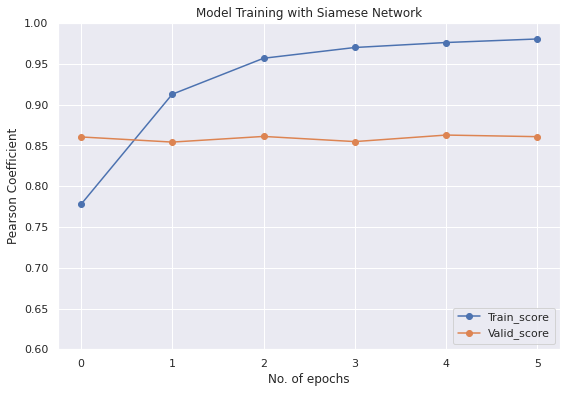

In [ ]:
#plot training and validation score
import matplotlib.pyplot as plt
import seaborn as sns
train_score = epochs_score['train_Pearson_score'] # train_score
valid_score = epochs_score['val_Pearson_score'] # valid_score
 

sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score ,'-o', label= 'Train_score' )#plot train score
plt.plot(valid_score, '-o', label='Valid_score') # plot valid score
plt.xticks( range(0, EPOCHS, 1)) #set xlabel location
plt.title('Model Training with Siamese Network') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0.6,1]) #set the ylabel limit
plt.legend(loc=4) #label 
plt.show()





In [ ]:
epochs_score

defaultdict(list,
            {'train_Pearson_score': [0.9095253426930726,
              0.9507620315805678,
              0.9658815727894156,
              0.969138802258031],
             'train_loss': [0.014850491575068897,
              0.008308044855948538,
              0.005935145596029341,
              0.005526766769859629],
             'val_Pearson_score': [0.8596345902946204,
              0.8628200338581528,
              0.8550283151967495,
              0.8579226058427706],
             'val_loss': [0.029453454192410758,
              0.028082741582964327,
              0.028189612146308447,
              0.0281864658315131]})

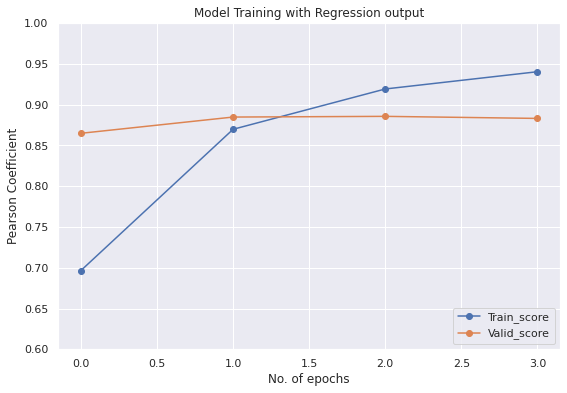

In [ ]:
#plot training and validation score
import matplotlib.pyplot as plt
import seaborn as sns
train_score = epochs_score['train_Pearson_score'] # train_score
valid_score = epochs_score['val_Pearson_score'] # valid_score
 
sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score ,'-o', label= 'Train_score' )#plot train score
plt.plot(valid_score, '-o', label='Valid_score') # plot valid score
plt.title('Model Training with Regression output') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0.6,1]) #set the ylabel limit
plt.legend(loc=4) #label 
plt.show()


# Evaluate on test

In [ ]:
#evaluate on test data Siamese Network model
test_loss, test_Pearson_score = model_eval(
                                      custom_model, 
                                      test_data_loader_cos, 
                                      device, 
                                      loss_fn,
                                      model_type[1] #Sieamese Network
                                      )
print(test_loss, test_Pearson_score)

0.03049802704146881 0.8359374742099637


In [ ]:
#evaluate on test data on Regression model
test_loss, test_Pearson_score = model_eval(
                                      custom_model, 
                                      test_data_loader_reg, 
                                      device, 
                                      loss_fn,
                                      model_type[0] # Linear Regression output
                                      )
print(test_loss, test_Pearson_score)

In [ ]:
print(test_loss, test_Pearson_score)

0.025870686771626444 0.847667453528674


# Save and Load model

In [ ]:
#save model
torch.save(custom_model.state_dict(), '/content/drive/My Drive/Google_Colab/cos_best_model.bin')

In [ ]:
#load model and evaluate on test data
fine_tuned_model = SentenceSimilarityModel()
fine_tuned_model.load_state_dict(torch.load('/content/drive/My Drive/Google_Colab/cos_best_model.bin'))
test_loss, test_Pearson_score = model_eval(
                                      fine_tuned_model.to(device),
                                      test_data_loader_cos, 
                                      device, 
                                      loss_fn,
                                      model_type[1]
                                      )
print(test_loss, test_Pearson_score)

0.030774633539305336 0.8418700599177172


In [ ]:
#copy model
!cp -r /content/reg_best_model.bin "/content/drive/My Drive/Google_Colab/cos_best_model.bin"

In [ ]:
#clear unused GPU
with torch.cuda.device('cuda:0'):
   torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Fri Jul  3 16:16:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    58W / 149W |   7417MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# References:
1. Chris McCormick and Nick Ryan. (2019, May 14). BERT Word Embeddings Tutorial. Retrieved from http://www.mccormickml.com , https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

2. Sentiment Analysis with BERT  https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=1zhHoFNsxufs&forceEdit=true&sandboxMode=true

3. Hugging Face Transformer, https://huggingface.co/transformers/

4. The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning), https://jalammar.github.io/illustrated-bert/

5. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, https://arxiv.org/abs/1810.04805
